In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Data import
with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split.h5') as store:
    X_cal = store.get('X_cal')
    Y_cal = store.get('Y_cal')
    X_test = store.get('X_test')
    Y_test = store.get('Y_test')

# Calibration and validation

R2_X:  0.7358288953526946
R2_Y:  0.4590841076783059
['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
(5, 22)


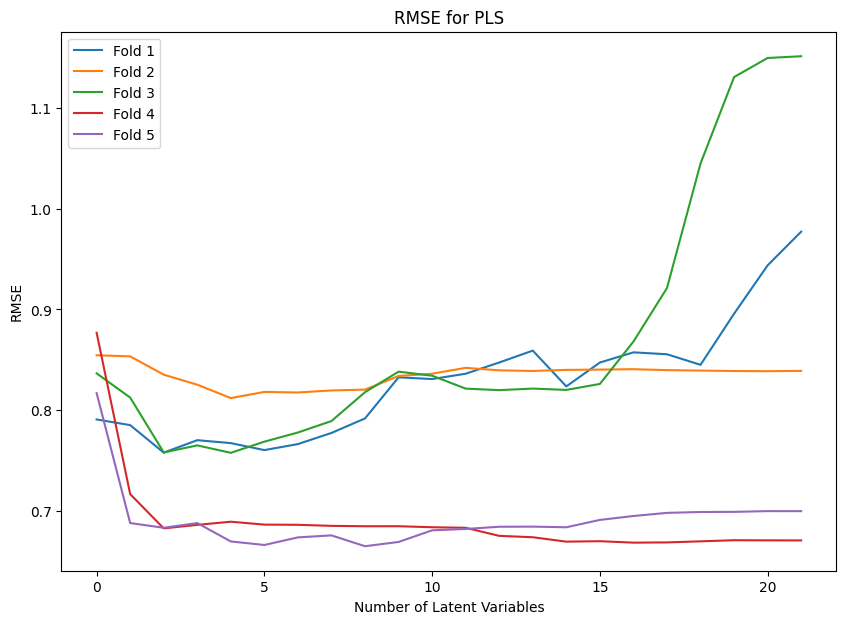

Optimal number of components for PLS: 5
Test RMSE for PLS: 0.7956112702002439


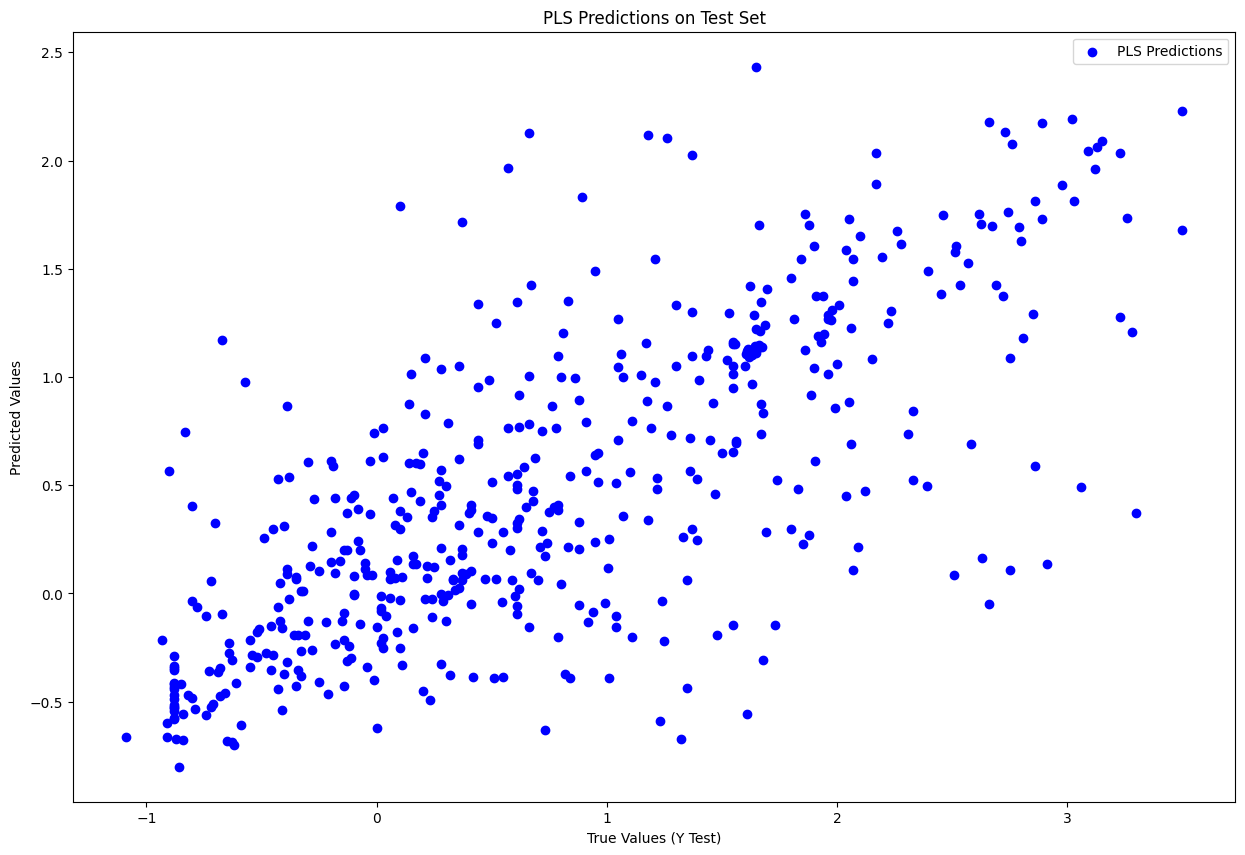

<function concatenate at 0x000002396B98BEF0>

In [105]:
# Standardize X_cal and apply the same transformation to X_test
scaler = StandardScaler()
X_cal_scaled = scaler.fit_transform(X_cal)
X_test_scaled = scaler.transform(X_test)

# Center Y_cal and apply the same transformation to Y_test
Y_cal_mean = np.mean(Y_cal)
Y_cal_centered = Y_cal - Y_cal_mean
Y_test_centered = Y_test - Y_cal_mean

# PLS Regression
pls = PLSRegression(n_components=7)
pls.fit(X_cal_scaled, Y_cal_centered)

# Variance explained in PLS
# R2_X_PLS = np.cumsum(np.var(pls.x_scores_, axis=0)) / np.var(X_cal_scaled, axis=0).sum()
# R2_Y_PLS = np.cumsum(np.var(pls.y_scores_, axis=0)) / np.var(Y_cal_centered)
TSS_X = np.sum( ( X_cal_scaled - np.mean(X_cal_scaled, axis=0) ) ** 2 ) 
TSS_Y = np.sum( ( Y_cal_centered.to_numpy() - np.mean(Y_cal_centered, axis=0) ) ** 2 )

RSS_Y = np.sum( ( Y_cal_centered.to_numpy().reshape( -1, 1 ) - pls.y_scores_ @ pls.y_loadings_.T  ) ** 2 )
# print( pls.y_scores_.shape , pls.y_loadings_.shape )
# print( ( ( Y_cal_centered.to_numpy() ) ).shape )
R2_X_PLS = 1 - np.sum( ( X_cal_scaled - pls.x_scores_ @ pls.x_loadings_.T ) ** 2 ) / TSS_X

print( "R2_X: ", R2_X_PLS )

R2_Y_PLS = pls.score( X_cal_scaled, Y_cal_centered )
print( "R2_Y: ", R2_Y_PLS)

# Plot the R^2 values for PLS
# plt.figure()
# plt.plot(R2_Y_PLS, label='PLS Explained Variance in Y')
# plt.title('PLS')
# plt.xlabel('Number of Latent Variables')
# plt.ylabel('R^2 [%]')
# plt.legend()
# plt.show()

# TimeSeriesSplit for cross-validation
cv_splits = 5
tscv = TimeSeriesSplit(n_splits=cv_splits)

RMSEPLS = np.zeros((cv_splits, 22))

for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_cal)):
    X_fold_cal, X_fold_val = X_cal.iloc[train_idx], X_cal.iloc[val_idx]
    Y_fold_cal, Y_fold_val = Y_cal.iloc[train_idx], Y_cal.iloc[val_idx]
    
    # Scale the training and validation sets
    scaler_fold = StandardScaler()
    X_fold_cal_scaled = scaler_fold.fit_transform(X_fold_cal)
    X_fold_val_scaled = scaler_fold.transform(X_fold_val)
    
    Y_fold_cal_mean = np.mean(Y_fold_cal)
    Y_fold_cal_centered = Y_fold_cal - Y_fold_cal_mean
    Y_fold_val_centered = Y_fold_val - Y_fold_cal_mean

    for j in range(1, 23):        
        # PLS
        pls_fold = PLSRegression(n_components=j)
        pls_fold.fit(X_fold_cal_scaled, Y_fold_cal_centered)
        Y_pred_val_pls = pls_fold.predict(X_fold_val_scaled).flatten()
        RMSEPLS[fold_idx, j-1] = root_mean_squared_error(Y_fold_val_centered, Y_pred_val_pls)

# Average RMSE over all folds
RMSE_CV_PLS = np.mean(RMSEPLS, axis=0)

# Plot RMSE for PLS
labels = [f'Fold {i+1}' for i in range(5)]
print( labels )
print(RMSEPLS.shape)
plt.figure( figsize=(10, 7) )
plt.plot(RMSEPLS.T, label=labels)
plt.title('RMSE for PLS')
plt.xlabel('Number of Latent Variables')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Optimal number of components based on RMSE
optimal_pls_components = np.argmin(RMSE_CV_PLS) + 1
print(f"Optimal number of components for PLS: {optimal_pls_components}")

# Re-calibrate the model with optimal components
pls_optimal = PLSRegression(n_components=optimal_pls_components)
pls_optimal.fit(X_cal_scaled, Y_cal_centered)

# Test set prediction
Y_test_pred_pls = pls_optimal.predict(X_test_scaled).flatten()

# Evaluate on test set
rmse_test_pls = root_mean_squared_error(Y_test_centered, Y_test_pred_pls)

print(f"Test RMSE for PLS: {rmse_test_pls}")

# Plot the test predictions for PLS
plt.figure( figsize=(15, 10) )
plt.scatter(Y_test_centered, Y_test_pred_pls, c='blue', label='PLS Predictions')
plt.xlabel('True Values (Y Test)')
plt.ylabel('Predicted Values')
plt.title('PLS Predictions on Test Set')
plt.legend()
plt.show()
np.concatenate